### **BITCOIN TRADING STRATEGY**

**Project goal**: To train classification algorithms on a bitcoin trading strategy problem and improve the performance of one machine learning model by tuning its parameters using grid search and Bayesian optimization technique. 

- The idea is to predict when to buy or sell bitcoin. We define buy or sell signal and represent them as 1 or 0. We arrive at the signal by comparing the price trend of short-term and long-term behavior, that is, short-term moving average greater than a long-term moving average. Then we buy bitcoin; otherwise, we sell bitcoin. This is, therefore, a classification problem where we are interested in getting the direction of Bitcoin movement right. 

**Loading Helper Packages and Data**

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

In [18]:
from time import time

import joblib

# display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


from bayes_opt import BayesianOptimization

# Libraries for Deep Learning Models
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# needed for `HistGradientBoostingClassifier`
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# from `keras.optimizers` import SGD

In [19]:
# To fetch financial data
import yfinance as yf

# Set the ticker as 'BTC-USD'
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="5y")

In [20]:
# BTC_Ticker = yf.Ticker("BTC-USD")
# BTC_Data = BTC_Ticker.history(period="max")
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-14 00:00:00+00:00,8140.933105,8879.511719,8140.933105,8827.764648,44841784107,0.0,0.0
2020-01-15 00:00:00+00:00,8825.343750,8890.117188,8657.187500,8807.010742,40102834650,0.0,0.0
2020-01-16 00:00:00+00:00,8812.481445,8846.460938,8612.095703,8723.786133,31313981931,0.0,0.0
2020-01-17 00:00:00+00:00,8725.209961,8958.122070,8677.316406,8929.038086,36372139320,0.0,0.0
2020-01-18 00:00:00+00:00,8927.211914,9012.198242,8827.332031,8942.808594,32337772627,0.0,0.0


**Exploratory Data Analysis**

In [5]:
BTC_Data.shape

(1828, 7)

In [6]:
BTC_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2020-01-14 00:00:00+00:00 to 2025-01-14 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1828 non-null   float64
 1   High          1828 non-null   float64
 2   Low           1828 non-null   float64
 3   Close         1828 non-null   float64
 4   Volume        1828 non-null   int64  
 5   Dividends     1828 non-null   float64
 6   Stock Splits  1828 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 114.2 KB


In [7]:
BTC_Data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.0,1828.0
mean,36933.638399,37742.576790,36093.541273,36979.393675,3.333415e+10,0.0,0.0
std,21580.702666,22050.431270,21097.788762,21612.710024,1.959561e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,5.331173e+09,0.0,0.0
25%,19982.574219,20355.200195,19612.807129,19986.950195,2.061794e+10,0.0,0.0
50%,33120.023438,34329.384766,31758.965820,33310.972656,3.012005e+10,0.0,0.0
75%,51732.856445,52534.219727,50526.316406,51755.625977,4.043503e+10,0.0,0.0
max,106147.296875,108268.445312,105291.734375,106140.601562,3.509679e+11,0.0,0.0


In [8]:
# Check for any null values and remove them
print("Null Values =", BTC_Data.isnull().values.any())

Null Values = False


**Data Preparation**

- We create a target variable, the buy or sell signal. The target variable constitutes our trading strategy. When the shorter term moving average goes above the longer term moving average, then it is an indicator to buy and the vice versa is also true. 

In [21]:
# Create short simple moving average over the short window
BTC_Data["short_moving_avg"] = (
    BTC_Data["Close"].rolling(window=10, min_periods=1, center=False).mean()
)

# Create long simple moving average over the long window
BTC_Data["long_maving_avg"] = (
    BTC_Data["Close"].rolling(window=60, min_periods=1, center=False).mean()
)

# Create signals
BTC_Data["signal"] = np.where(
    BTC_Data["short_moving_avg"] > BTC_Data["long_maving_avg"], 1.0, 0.0
)

In [22]:
BTC_Data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal
Date,,,,,,,,,,
2020-01-14 00:00:00+00:00,8140.933105,8879.511719,8140.933105,8827.764648,44841784107,0.0,0.0,8827.764648,8827.764648,0.0
2020-01-15 00:00:00+00:00,8825.343750,8890.117188,8657.187500,8807.010742,40102834650,0.0,0.0,8817.387695,8817.387695,0.0
2020-01-16 00:00:00+00:00,8812.481445,8846.460938,8612.095703,8723.786133,31313981931,0.0,0.0,8786.187174,8786.187174,0.0
2020-01-17 00:00:00+00:00,8725.209961,8958.122070,8677.316406,8929.038086,36372139320,0.0,0.0,8821.899902,8821.899902,0.0
2020-01-18 00:00:00+00:00,8927.211914,9012.198242,8827.332031,8942.808594,32337772627,0.0,0.0,8846.081641,8846.081641,0.0


**Feature Engineering**

We create additional features in our dataset that will help us improve our model performance:

- Exponentail Moving Average: Gives us the price trend of the data.
- Relative Strength Indicator (RSI): Measures the change in price in recent time frame.
- Rate of change: Measures the percentage change between the stock's current price and past prices. 
- Stochastic Oscillator: Compares the current closing price of the stock with its previous closing price.

In [23]:
# calculation of exponential moving average


def EMA(df, n):
    EMA = pd.Series(df["Close"].ewm(span=n, min_periods=n).mean(), name="EMA_" + str(n))
    return EMA


BTC_Data["EMA10"] = EMA(BTC_Data, 10)
BTC_Data["EMA30"] = EMA(BTC_Data, 30)
BTC_Data["EMA200"] = EMA(BTC_Data, 200)
BTC_Data.head()


# calculation of rate of change
def RC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    RC = pd.Series(((M / N) * 100), name="RC_" + str(n))
    return RC


BTC_Data["RC10"] = RC(BTC_Data["Close"], 10)
BTC_Data["RC30"] = RC(BTC_Data["Close"], 30)


# Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name="Momentum_" + str(n))
    return MOM


BTC_Data["MOM10"] = MOM(BTC_Data["Close"], 10)
BTC_Data["MOM30"] = MOM(BTC_Data["Close"], 30)


# calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period - 1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[: (period - 1)])
    d[d.index[period - 1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[: (period - 1)])
    rs = (
        u.ewm(com=period - 1, adjust=False).mean()
        / d.ewm(com=period - 1, adjust=False).mean()
    )
    return 100 - 100 / (1 + rs)


BTC_Data["RSI10"] = RSI(BTC_Data["Close"], 10)
BTC_Data["RSI30"] = RSI(BTC_Data["Close"], 30)
BTC_Data["RSI200"] = RSI(BTC_Data["Close"], 200)

# calculation of stochastic oscillator.


def STOK(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    return STOK


def STOD(close, low, high, n):
    STOK = (
        (close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())
    ) * 100
    STOD = STOK.rolling(3).mean()
    return STOD


BTC_Data["%K10"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%D10"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 10)
BTC_Data["%K30"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%D30"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 30)
BTC_Data["%K200"] = STOK(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)
BTC_Data["%D200"] = STOD(BTC_Data["Close"], BTC_Data["Low"], BTC_Data["High"], 200)

In [25]:
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-10 00:00:00+00:00,92494.492188,95770.609375,92250.093750,94701.453125,62058693684,0.0,0.0,96719.505469,96513.496875,1.0,95964.237026,96294.762600,78116.654015,0.298344,-5.339251,1272.250000,-6471.578125,45.281719,51.511361,55.399399,30.288185,24.660485,20.417003,16.603240,77.062328,76.005449
2025-01-11 00:00:00+00:00,94700.835938,94977.687500,93840.046875,94566.593750,18860894100,0.0,0.0,96734.189062,96623.676562,1.0,95710.120067,96183.267835,78280.335009,-2.394835,-6.793529,146.835938,-5476.406250,44.946838,51.379882,55.370527,29.114642,23.465041,19.625928,15.817581,76.834322,75.736668
2025-01-12 00:00:00+00:00,94565.726562,95367.539062,93712.507812,94488.437500,20885130965,0.0,0.0,96494.345312,96688.747786,0.0,95487.995964,96073.923943,78441.609663,-3.688805,-6.791289,-2398.437500,-6970.820312,44.733806,51.301379,55.353723,28.434528,29.279118,19.167469,19.736800,76.702183,76.866278
2025-01-13 00:00:00+00:00,94488.890625,95837.000000,89260.101562,94516.523438,72978998252,0.0,0.0,96135.254687,96809.849349,0.0,95311.364595,95973.446491,78601.559056,-3.786488,-9.378997,-3590.906250,-6856.445312,44.838198,51.329023,55.358616,39.074281,32.207817,27.653235,22.148877,76.749668,76.762058
2025-01-14 00:00:00+00:00,94510.078125,97246.203125,94330.820312,96524.117188,69352521728,0.0,0.0,95964.043750,96900.817839,0.0,95531.865067,96008.973633,78779.892969,-1.821537,-8.965035,-1712.109375,-7774.578125,52.034069,53.289763,55.707323,53.997985,40.502265,38.214879,28.345194,80.143901,77.865251


Next, we claculate moving averages:

In [26]:
def MA(df, n):
    MA = pd.Series(df["Close"].rolling(n, min_periods=n).mean(), name="MA_" + str(n))
    return MA


BTC_Data["MA21"] = MA(BTC_Data, 10)
BTC_Data["MA63"] = MA(BTC_Data, 30)
BTC_Data["MA252"] = MA(BTC_Data, 200)
BTC_Data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,short_moving_avg,long_maving_avg,signal,EMA10,EMA30,EMA200,RC10,RC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-10 00:00:00+00:00,92494.492188,95770.609375,92250.093750,94701.453125,62058693684,0.0,0.0,96719.505469,96513.496875,1.0,95964.237026,96294.762600,78116.654015,0.298344,-5.339251,1272.250000,-6471.578125,45.281719,51.511361,55.399399,30.288185,24.660485,20.417003,16.603240,77.062328,76.005449,96719.505469,97718.195312,73128.964141
2025-01-11 00:00:00+00:00,94700.835938,94977.687500,93840.046875,94566.593750,18860894100,0.0,0.0,96734.189062,96623.676562,1.0,95710.120067,96183.267835,78280.335009,-2.394835,-6.793529,146.835938,-5476.406250,44.946838,51.379882,55.370527,29.114642,23.465041,19.625928,15.817581,76.834322,75.736668,96734.189062,97535.648438,73292.773906
2025-01-12 00:00:00+00:00,94565.726562,95367.539062,93712.507812,94488.437500,20885130965,0.0,0.0,96494.345312,96688.747786,0.0,95487.995964,96073.923943,78441.609663,-3.688805,-6.791289,-2398.437500,-6970.820312,44.733806,51.301379,55.353723,28.434528,29.279118,19.167469,19.736800,76.702183,76.866278,96494.345312,97303.287760,73461.159707
2025-01-13 00:00:00+00:00,94488.890625,95837.000000,89260.101562,94516.523438,72978998252,0.0,0.0,96135.254687,96809.849349,0.0,95311.364595,95973.446491,78601.559056,-3.786488,-9.378997,-3590.906250,-6856.445312,44.838198,51.329023,55.358616,39.074281,32.207817,27.653235,22.148877,76.749668,76.762058,96135.254687,97074.739583,73625.718320
2025-01-14 00:00:00+00:00,94510.078125,97246.203125,94330.820312,96524.117188,69352521728,0.0,0.0,95964.043750,96900.817839,0.0,95531.865067,96008.973633,78779.892969,-1.821537,-8.965035,-1712.109375,-7774.578125,52.034069,53.289763,55.707323,53.997985,40.502265,38.214879,28.345194,80.143901,77.865251,95964.043750,96815.586979,73806.738223


- We now move features that are irrelevant to our prediction such as High, Low, and Open values. We drop the short and long moving average features since we have already defined our trading signals.

In [27]:
# excluding columns that are not needed for our prediction.

BTC_Data = BTC_Data.drop(
    [
        "High",
        "Low",
        "Open",
        "short_moving_avg",
        "long_maving_avg",
        "Dividends",
        "Stock Splits",
    ],
    axis=1,
)

In [28]:
BTC_Data = BTC_Data.dropna(axis=0)

- Visualizing the Bitcoin price trend over the four years:

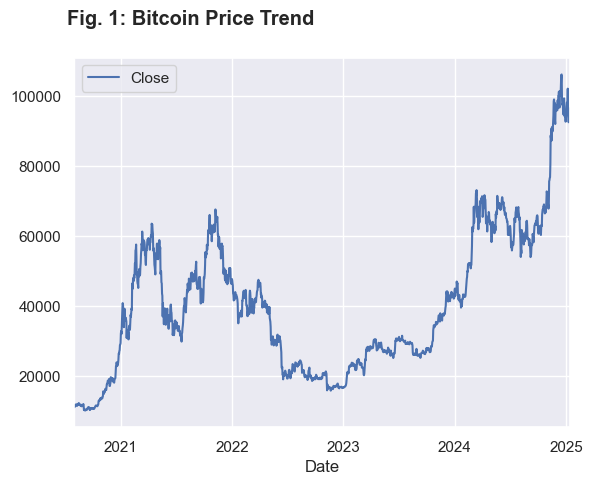

In [29]:
BTC_Data[["Close"]].plot(grid=True)
plt.suptitle(
    "Fig. 1: Bitcoin Price Trend", fontweight="bold", horizontalalignment="right"
)
plt.show()

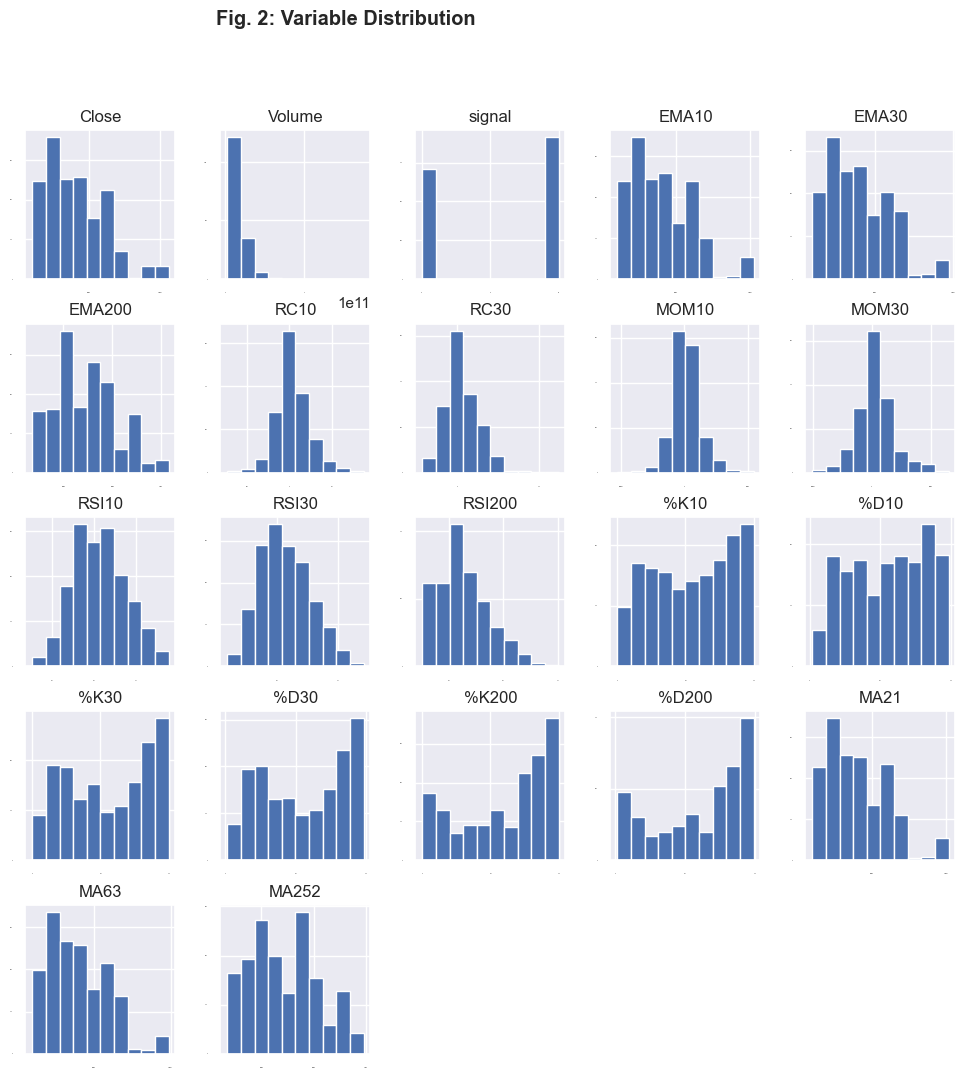

In [31]:
# Histograms
BTC_Data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12, 12))
plt.suptitle(
    "Fig. 2: Variable Distribution", fontweight="bold", horizontalalignment="right"
)
plt.show()

- Visualize the proportion of sell to buy signals in our dataset.

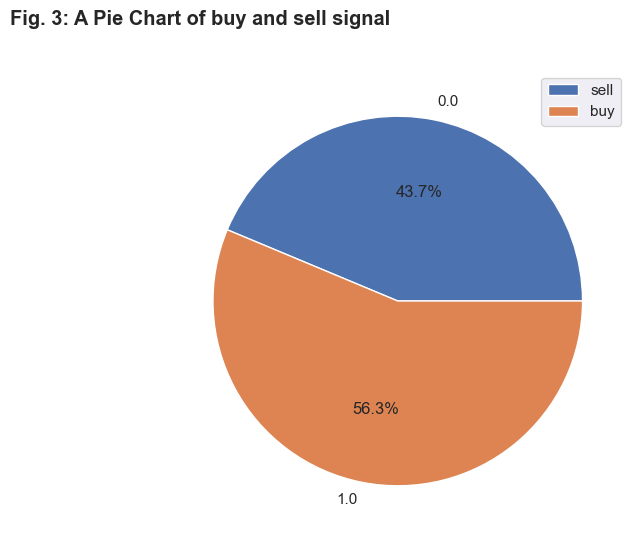

In [32]:
fig = plt.figure()
plot = (
    BTC_Data.groupby("signal")
    .size()
    .plot(kind="pie", figsize=(6, 6), autopct="%1.1f%%", y="signal")
)
plt.suptitle(
    "Fig. 3: A Pie Chart of buy and sell signal",
    fontweight="bold",
    horizontalalignment="right",
)
plt.legend(["sell", "buy"])
plt.show()

In [33]:
BTC_Data.groupby(["signal"]).size()

signal
0.0    711
1.0    916
dtype: int64

- Relationship between our variables using a correlation matrix of the returns.

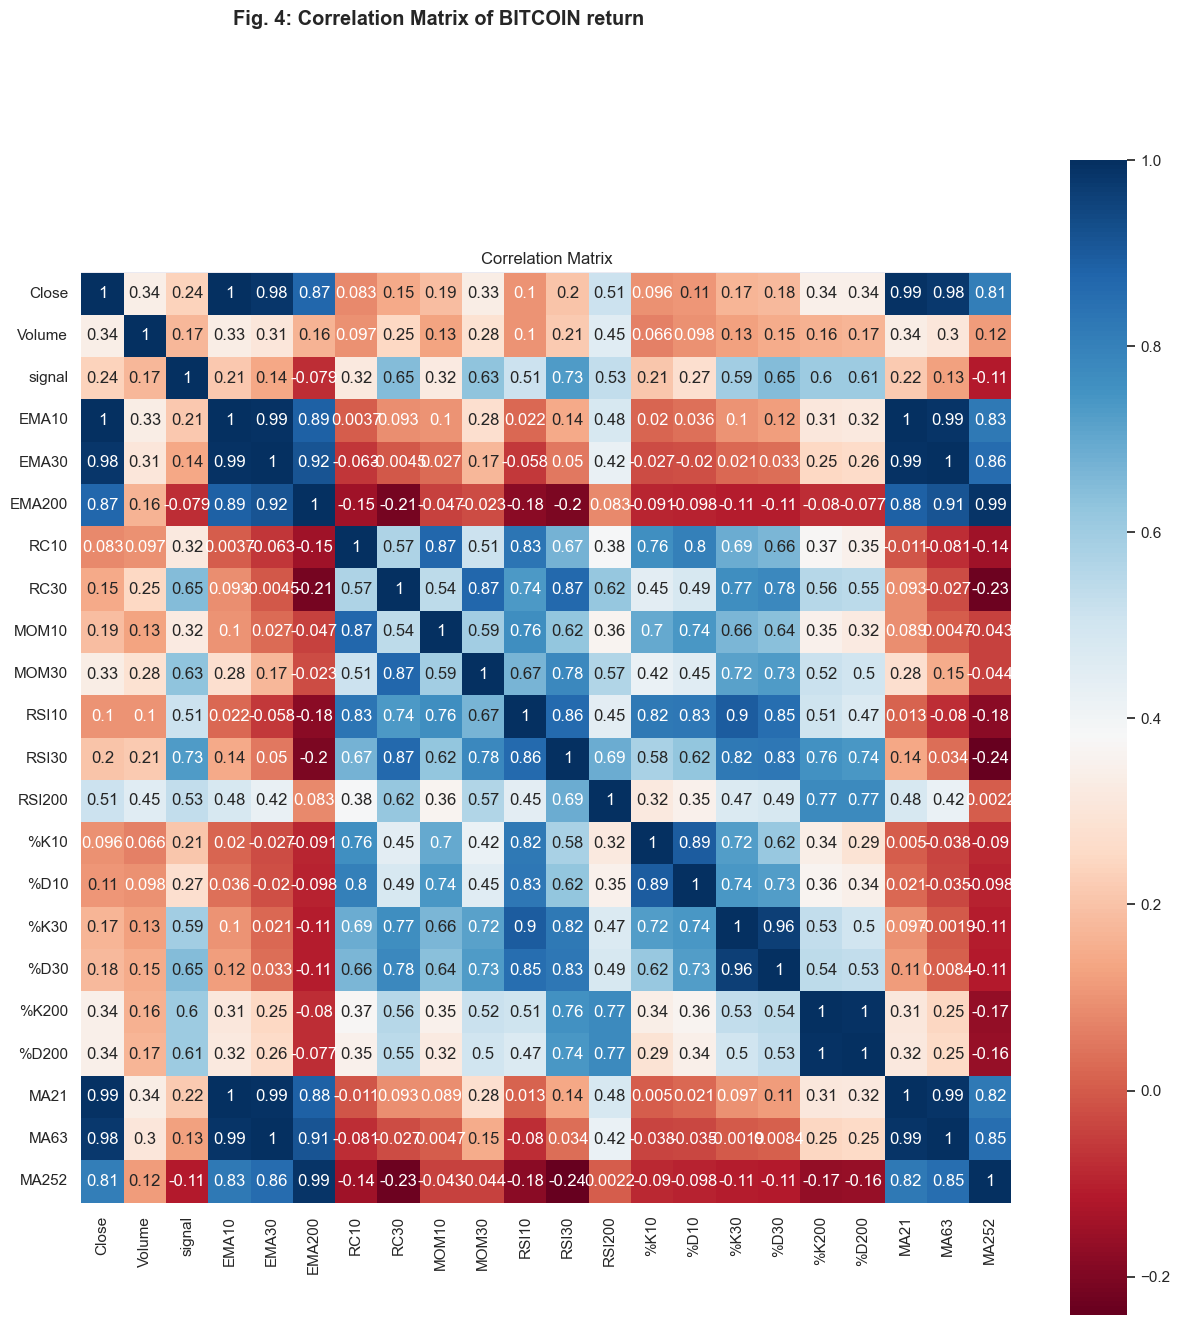

In [35]:
# correlation
BTC_Data_returns = BTC_Data.shift()
correlation = BTC_Data_returns.corr()
plt.figure(figsize=(15, 15))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap="RdBu")
plt.suptitle(
    "Fig. 4: Correlation Matrix of BITCOIN return",
    fontweight="bold",
    horizontalalignment="right", 
)
plt.show()

**Modeling**

In [36]:
# Train Test split with 80:20 ratio
def get_holdout_set(target, features, period=6):
    idx =pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values("Date").unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start:cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start:holdout_endl, :]]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [37]:
subset_validation = BTC_Data[1301:]

In [38]:
subset_validation.shape

(326, 22)

In [39]:
# split out validation dataset for the end
subset_dataset = BTC_Data[:1300]
y = subset_dataset["signal"]
X = subset_dataset.loc[:, BTC_Data.columns != "signal"]
X.index = pd.to_datetime(X.index)
validation_size = 0.2
seed = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=validation_size, random_state=1
)

In [40]:
subset_dataset.shape

(1300, 22)

- We create a validation dataset that consists of the remaining data we did not pick in the subset. This validation dataset will only  be used in basktesting our model.

In [41]:
subset_validation = BTC_Data[1300:]
y_validation = subset_validation["signal"]
X_validation = subset_validation.loc[:, BTC_Data.columns != "signal"]

In [42]:
X_validation.shape

(327, 21)

**Baseline Classifier**

- It's important to train a baseline classifier that will be used to compare with the real classifiers. We use the sklearn ```DummyClassifier``` as our baseline classifier and choose ```strategy=stratified``` that predicts the most frequent class.

In [43]:
# test options for classification
num_folds = 10
seed = 42
scoring = "accuracy"
metrics = {
    "balanced_accuary": "accuracy",
    "roc_auc":"AUC",
    "neg_log_loss":"Log Loss",
    "f1_weighted": "F1",
    "precision_weighted": "Precision", 
    "recall_weighted": "Recall",
}

Cross-valiation function that will help us evaluate different algorithms: